In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import mrcfile
import math
from scipy import fftpack, interpolate, linalg, ndimage
%matplotlib inline

In [12]:
def project_fst(rho, a, b):
    """
    RGI method
    """
    rho_hat = np.fft.fftshift(np.fft.fftn(rho))
    N = len(rho)
    
    etax, etay = np.meshgrid(np.arange(-(N-1)/2 , (N-1)/2 + 1, dtype=int), np.arange(-(N-1)/2, (N-1)/2 + 1, dtype=int), indexing='ij')
    etax = etax[..., np.newaxis]
    etay = etay[..., np.newaxis]
    
    grid = etax * a + etay * b #200x200x3
    
    wx, wy, wz = np.meshgrid(np.arange(-(N-1)/2 , (N-1)/2 + 1, dtype=int), np.arange(-(N-1)/2 , (N-1)/2 + 1, dtype=int), np.arange(-(N-1)/2 , (N-1)/2 + 1, dtype=int))
    
#     rho_hat = ((-1)**np.abs((wx + wy + wz))) * 1/N**3 * rho_hat
    rho_hat = np.exp(np.pi * 1j * (wx + wy + wz)) / N**3 * rho_hat
#     print(((-1)**np.abs((wx + wy + wz))))

    x = np.arange(-(N-1)/2, (N-1)/2+1)
    y = np.arange(-(N-1)/2, (N-1)/2+1)
    z = np.arange(-(N-1)/2, (N-1)/2+1)

    
    rho_hat_f = interpolate.RegularGridInterpolator(points=[x, y, z], values=rho_hat, bounds_error=False, fill_value=0)
    result = rho_hat_f(grid)
    
#     result = ((-1)**np.abs((etax[...,0] + etay[...,0] + 1)))*N**2*result
    result = np.exp(-np.pi * 1j * (etax[..., 0] + etay[..., 0]))* N**2 * result
    image = np.fft.ifftn(np.fft.ifftshift(result))
    
#     print(np.linalg.norm(np.imag(image)))

    return image.real

In [79]:
def back_projection(I):
    # compute image_hat
    N = len(I)
    image_hat = np.fft.fftshift(np.fft.fftn(I))
    # scale
    etax, etay = np.meshgrid(np.arange(-(N-1)/2 , (N-1)/2 + 1, dtype=int), np.arange(-(N-1)/2, (N-1)/2 + 1, dtype=int), indexing='ij')
    image_hat = np.exp(np.pi * 1j * (etax + etay)) * N**2 * image_hat
    
    # compute F{l_j}
    wz = np.arange(-(N-1)/2, (N-1)/2+1)
    l_j_hat = np.sinc(wz)
    
    # tiling
    l_j_hat_tiled = np.tile(l_j_hat, (N, N, 1))
    I_j_hat = np.tile(image_hat[..., np.newaxis], (1, 1, N))
    
    b_j_hat = I_j_hat * l_j_hat
    # scale
#     w_x, w_y, w_z = np.meshgrid(np.arange(-(N-1)/2 , (N-1)/2 + 1, dtype=int), np.arange(-(N-1)/2 , (N-1)/2 + 1, dtype=int), np.arange(-(N-1)/2 , (N-1)/2 + 1, dtype=int))
#     b_j_hat = np.exp(-np.pi * 1j * (w_x + w_y + w_z)) / N**3 * b_j_hat
    
    #inverse fft
#     b_j = np.fft.ifftn(np.fft.ifftshift(b_j_hat))
    return (b_j_hat, np.sum(l_j_hat))

In [96]:
def reconstruction(rho, k_images):
    
    sum_b_j_hat = 0
    sum_l_j_hat = 0
    
    for i in np.arange(k_images):
        
        a = 2*np.random.rand(3)-1
        b = np.cross(a, 2*np.random.rand(3)-1)
        a = a/np.linalg.norm(a)
        b = b/np.linalg.norm(b)
        
        image = project_fst(rho, a, b)
        bp_result = back_projection(image)
        b_j_hat = bp_result[0]
        l_j_hat = bp_result[1]
        
        N = len(image)
        
        # rotated coordinates
        rot_x, rot_y, rot_z = (np.meshgrid(np.arange(-(N-1)/2 , (N-1)/2 + 1, dtype=int), 
                               np.arange(-(N-1)/2 , (N-1)/2 + 1, dtype=int),
                               np.arange(-(N-1)/2 , (N-1)/2 + 1, dtype=int)))
        
        rot_x = rot_x[..., np.newaxis] * a
        rot_y = rot_y[..., np.newaxis] * b
        rot_z = rot_z[..., np.newaxis] * np.cross(a, b)
        
        grid = rot_x + rot_y + rot_z
        
        # standard coordinates
        x = np.arange(-(N-1)/2, (N-1)/2+1)
        y = np.arange(-(N-1)/2, (N-1)/2+1)
        z = np.arange(-(N-1)/2, (N-1)/2+1)
        
        b_j_hat_f = (interpolate.RegularGridInterpolator(points=[x, y, z], 
                                                     values=bp_result[0], bounds_error=False, fill_value=0))
        
        interpolated = b_j_hat_f(grid)
        w_x, w_y, w_z = np.meshgrid(np.arange(-(N-1)/2 , (N-1)/2 + 1, dtype=int), np.arange(-(N-1)/2 , (N-1)/2 + 1, dtype=int), np.arange(-(N-1)/2 , (N-1)/2 + 1, dtype=int))
        interpolated = np.exp(-np.pi * 1j * (w_x + w_y + w_z)) / N**3 * interpolated
        sum_b_j_hat += interpolated
        sum_l_j_hat += l_j_hat
        
    final_recon = np.fft.ifftn(np.fft.ifftshift(sum_b_j_hat/sum_l_j_hat))
    return final_recon.real

In [99]:
test = reconstruction(small_rho, 10)
test.shape

(153, 153, 153)

In [14]:
zika_small = mrcfile.open('zika_153.mrc')
small_rho = zika_small.data

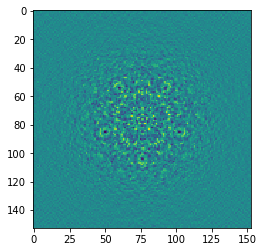

In [15]:
plt.imshow(small_rho[0])

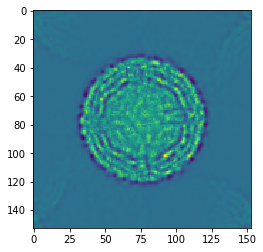

In [50]:
a = 2*np.random.rand(3)-1
b = np.cross(a, 2*np.random.rand(3)-1)
a = a/np.linalg.norm(a)
b = b/np.linalg.norm(b)
I = project_fst(small_rho, a, b)
# test.shape
plt.imshow(I)

In [56]:
back_projection_test = back_projection(I)

In [57]:
back_projection_test = (np.fft.ifftn(np.fft.fftshift(back_projection_test[0]))).real

In [100]:
# Using mode 'r+' allows read and write access:
mrc = mrcfile.new('temp_10.mrc', overwrite=True)
mrc.set_data(test.astype('float32'))
# as con
mrc.data
mrc.close()

In [38]:
projected_image = mrcfile.new('project_I.mrc', overwrite=True)
projected_image.set_data(I.astype('float32'))
projected_image.data
projected_image.close()